Imports

In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
#from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
import re

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

Dataset

In [ ]:
drive.mount('/content/gdrive')
#df = pd.read_csv ('/content/gdrive/MyDrive/Celonis/labelled_text.csv', encoding='latin-1')
df = pd.read_csv ('/content/gdrive/MyDrive/Celonis/pluskaggle.csv')
df = df.sample(frac=1).reset_index(drop=True) #shuffle

In [ ]:
# from io import StringIO
col = ['sentiment', 'origin','text']
df = df[col]
df = df[pd.notnull(df['text'])]

In [ ]:
df['sentiment_id'] = df['sentiment'].factorize()[0]
sentiment_id_df = df[['sentiment', 'sentiment_id']].drop_duplicates().sort_values('sentiment_id')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['sentiment_id', 'sentiment']].values)
#df.head()
print (id_to_sentiment) #{0: 'Negative', 1: 'Positive', 2: 'Irrelevant'}

{0: 'Negative', 1: 'Positive', 2: 'Irrelevant'}


Pre processing

In [ ]:
#Preparo las funciones para normalizar, lematizar y eliminar stopwords. 

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat = r'|'.join((pat1, pat2, pat3))

filtrar=['borderlands', 'callofdutyblackopscoldwar', 'amazon', 'overwatch', 'xbox(xseries)', 'nba2k', 'dota2', 'playstation5(ps5)', 'worldofcraft', 'csgo', 'google', 'assassinscreed', 'apexlegends',
       'leagueoflegends', 'fortnite', 'microsoft', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'verizon', 'homedepot', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
       'tomclancysrainbowsix', 'facebook', 'grandtheftauto(gta)', 'maddennfl', 'johnson&johnson', 'cyberpunk2077', 'tomclancysghostrecon', 'nvidia']

filtrar2=['borderlands', 'callofdutyblackopscoldwar', 'amazon', 'overwatch', 'xbox(xseries)', 'nba2k', 'dota2', 'playstation5(ps5)', 'worldofcraft', 'csgo', 'google', 'assassinscreed', 'apexlegends',
       'leagueoflegends', 'fortnite', 'microsoft', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'verizon', 'homedepot', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
       'tomclancysrainbowsix', 'facebook', 'grandtheftauto(gta)', 'maddennfl', 'johnson&johnson', 'cyberpunk2077', 'tomclancysghostrecon', 'nvidia', 'game']

games_origin = ['borderlands', 'callofdutyblackopscoldwar','overwatch', 'nba2k','dota2', 'worldofcraft', 'csgo', 'assassinscreed', 'apexlegends', 
                'leagueoflegends', 'fortnite', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
                'tomclancysrainbowsix','grandtheftauto(gta)', 'maddennfl', 'cyberpunk2077', 'tomclancysghostrecon']

def get_clean_text (origin, text):
    origin = str (origin)
    origin = origin.lower()
    text = str (text)
    text = text.lower() # lowercase
    if origin in games_origin:
      text = re.sub(pat, ' ', text) # remove pat
      text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
      text = [w for w in text if w not in filtrar2]
      text = [w for w in text if len(w)>2] # remove words with len <2
      text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text] # Aplicamos el Lemmatizer
      text = (' '.join(text)).strip() # list to string
    else:
      text = re.sub(pat, ' ', text) # remove pat
      text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
      text = [w for w in text if w not in filtrar]
      text = [w for w in text if len(w)>2] # remove words with len <2
      text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text] # Aplicamos el Lemmatizer
      text = (' '.join(text)).strip() # list to string      
    return text

In [ ]:
df['text_clean'] = df.apply(lambda x: get_clean_text(x.origin, x.text), axis=1)
df.drop_duplicates(subset='text_clean', keep="first", inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text_clean, df.sentiment_id, test_size = 0.20, stratify=df.sentiment_id, random_state = 12)

Tokenization.

In [ ]:
tokenizer=nltk.tokenize.word_tokenize
#tfidf 
tfidf_vect = TfidfVectorizer (tokenizer=tokenizer, min_df=2, ngram_range=(1,2))
# fit transform to train and transform of test
X_train = tfidf_vect.fit_transform (X_train)
X_test= tfidf_vect.transform (X_test)

In [ ]:
# Dump the file
import pickle
pickle.dump(tfidf_vect, open("tfidf1.pkl", "wb"))

A confusion matrix function to study my results

In [ ]:
import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

I have performed a simple analysis with several models that I thought that could perform correctly. 
Once I selected the best one I carried out a grid search to fine tune. 

In [ ]:
#SVC
# SVC= LinearSVC (random_state=12,multi_class='ovr')

# SVC.fit(X_train,y_train)

# # param_grid = {'loss': ['hinge', 'squared_hinge']}

# # grid_search = GridSearchCV(SVC, param_grid=param_grid, cv=5, 
# #                            scoring='accuracy', #https://scikit-learn.org/stable/modules/model_evaluation.html
# #                            return_train_score=True)

SVC= LinearSVC (random_state=12, multi_class='ovr', loss = 'squared_hinge')
SVC.fit (X_train,y_train)
optimised_svm = SVC

Confusion matrix, without normalization
[[5020  156  156]
 [ 213 4175  169]
 [ 160  160 4764]]


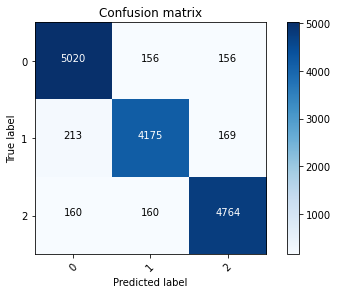

In [ ]:
# # Mostrá la matriz de confusión en esta celda
y_pred= optimised_svm.predict(X_test)

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,id_to_sentiment)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) #{0: 'Negative', 1: 'Positive', 2: 'Irrelevant'}

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5332
           1       0.93      0.92      0.92      4557
           2       0.94      0.94      0.94      5084

    accuracy                           0.93     14973
   macro avg       0.93      0.93      0.93     14973
weighted avg       0.93      0.93      0.93     14973



In [ ]:
#Training over complete dataset
X = tfidf_vect.transform (df.text_clean)
y = df.sentiment_id

In [ ]:
from sklearn.svm import LinearSVC
SVC= LinearSVC (random_state=12, multi_class='ovr', loss = 'squared_hinge')
SVC.fit (X,y)
total_svm = SVC

In [ ]:
import joblib
joblib.dump(total_svm, 'sentiment_svm.pkl') 

['sentiment_svm.pkl']

In [ ]:
#mini test
prediction_map = {0: 'Negative message', 1: 'Positive message', 2: 'Irrelevant message'}
string = 'This is a very good day'
string = get_clean_text ('hola',string)
string = [string]
string = tfidf_vect.transform (string)
pred_string = (total_svm.predict (string).item())
print (pred_string)
print (prediction_map.get(pred_string))

1
Positive message


# Other models

In [ ]:
rfc = RandomForestClassifier(random_state=12)
rfc.fit (X_train,y_train)
optimised_rf = rfc 

RandomForestClassifier(random_state=12)

Confusion matrix, without normalization
[[4893  207  234]
 [ 218 4621  240]
 [ 318  248 3994]]


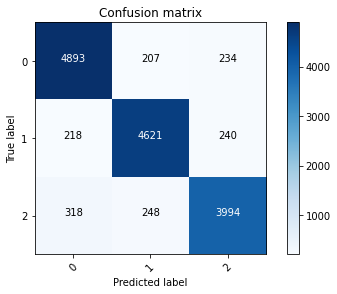

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      5334
           1       0.91      0.91      0.91      5079
           2       0.89      0.88      0.88      4560

    accuracy                           0.90     14973
   macro avg       0.90      0.90      0.90     14973
weighted avg       0.90      0.90      0.90     14973



In [ ]:
y_pred= optimised_rf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,id_to_sentiment)
print(classification_report(y_test, y_pred))

In [ ]:
mlp_clf = MLPClassifier(random_state=12)
mlp_clf.fit (X_train,y_train)
optimised_mlp = mlp_clf

MLPClassifier(random_state=12)

Confusion matrix, without normalization
[[2710  109   64   99]
 [  71 3343   91  101]
 [  49   88 1866   98]
 [ 103  117  114 2789]]


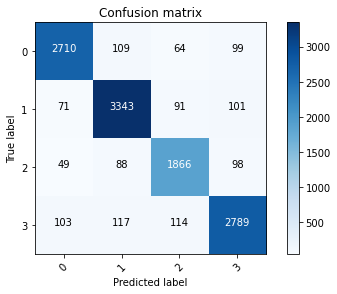

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2982
           1       0.91      0.93      0.92      3606
           2       0.87      0.89      0.88      2101
           3       0.90      0.89      0.90      3123

    accuracy                           0.91     11812
   macro avg       0.90      0.90      0.90     11812
weighted avg       0.91      0.91      0.91     11812



In [ ]:
y_pred= optimised_mlp.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,id_to_sentiment)
print(classification_report(y_test, y_pred)) #, target_names=id_to_sentiment.get(y_pred)

In [ ]:
import xgboost as xgb
clf_XGB = xgb.XGBClassifier()
clf_XGB.fit(X_train, y_train)

y_pred= clf_XGB.predict(X_test)

##Mostrá los resultados de la predicción del random forest sobre el conjunto de test con una matriz de confusión
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,id_to_sentiment)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) #, target_names=id_to_sentiment.get(y_pred)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

voting_clf = VotingClassifier(
estimators=[('svc', SVC), ('rf', optimised_rf), ('mlp', optimised_mlp)],voting='hard') 
trained_voting_clf = voting_clf.fit(X_train, y_train)
for clf in (optimised_rf, optimised_mlp, voting_clf,SVC):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8944293938367761
MLPClassifier 0.9065357263799526
VotingClassifier 0.9265154080596004
LinearSVC 0.9265154080596004


In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [ ]:
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.2.5.
